## Classifying Moderns and Ancients based on damage signatures 

In this script, we take into account a known damage signature, C to T along the read and use that to classify moderns and ancients and determine a classifier. We are trying to learn about the ancient and modern samples from these damage signatures. Here we

- Perform a PCA on the pooled data from different sources using C to T with position information
- Perform Structure based on the C to T counts with position information
- Define a classifier (SVM) training on ancients (Sherpa + gosling ancient) and moderns (HGDP + 1000 Genomes) and then 
  testing it on the Sardinia and the Gosling controls
- Use classtpx to do a supervised GoM model fit on the same.

In [32]:
options(warn=-1)
library(aRchaic)
library(CountClust)
library(maptpx)
library(grid)
library(gridBase)
library(plyr)
library(dplyr)
library(limma)
library(e1071)
library(classtpx)

Loading required package: slam

Attaching package: ‘classtpx’

The following objects are masked from ‘package:maptpx’:

    expit, logit, rdir, stm_tfidf



In [36]:
## Pool data from different sources

sardinia_counts <- get(load("../processed_data/sardinia2017.rda"))
temp <- club_signature_counts(sardinia_counts)
sardinia_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
sardinia_counts_CtoT <- filter_signatures_only_location(sardinia_counts_CtoT, max_pos = 10)



lindo_ancients_counts <- get(load("../processed_data/lindo2016ancients-counts-table.rda"))
temp <- club_signature_counts(lindo_ancients_counts)
lindo_ancients_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop=TRUE)
lindo_ancients_counts_CtoT <- filter_signatures_only_location(lindo_ancients_counts_CtoT, max_pos = 10)


lindo_moderns_counts <- get(load("../processed_data/lindo2016moderns-counts-table.rda"))
temp <- club_signature_counts(lindo_moderns_counts)
lindo_moderns_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
lindo_moderns_counts_CtoT <- filter_signatures_only_location(lindo_moderns_counts_CtoT, max_pos = 10)

gosling_counts <- get(load("../processed_data/annagosling2016-counts-table.rda"))
temp <- club_signature_counts(gosling_counts)
temp <- temp[-28,];
gosling_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
gosling_counts_CtoT <- filter_signatures_only_location(gosling_counts_CtoT, max_pos = 10)

sherpa_counts <- get(load("../processed_data/sherpa2017.rda"))
temp <- club_signature_counts(sherpa_counts)
sherpa_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
sherpa_counts_CtoT <- filter_signatures_only_location(sherpa_counts_CtoT, max_pos = 10)

thousandg_counts_clubbed <- get(load("../processed_data/1000Gmoderns-clubbed_counts-table.rda"))
temp <- thousandg_counts_clubbed
thousandg_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
thousandg_counts_CtoT <- filter_signatures_only_location(thousandg_counts_CtoT, max_pos = 10)

hgdp_counts <- get(load("../processed_data/HGDPmoderns-counts-table.rda"))
temp <- club_signature_counts(hgdp_counts)
hgdp_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
hgdp_counts_CtoT <- filter_signatures_only_location(hgdp_counts_CtoT, max_pos = 10)

names <- rownames(gosling_counts);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

gosling_controls_counts_CtoT <- gosling_counts_CtoT[control_indices,]
gosling_ancient_counts_CtoT <- gosling_counts_CtoT[-control_indices,]

I_counts <- get(load("../processed_data/Idata-counts-table.rda"))
temp <- club_signature_counts(I_counts)
I_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
I_counts_CtoT <- filter_signatures_only_location(I_counts_CtoT, max_pos = 10)

RISE_counts <- get(load("../processed_data/RISE-counts-table.rda"))
temp <- club_signature_counts(RISE_counts)
RISE_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = TRUE)
RISE_counts_CtoT <- filter_signatures_only_location(RISE_counts_CtoT, max_pos = 10)

In [37]:
ll <- list()
#ll[["lindo-moderns"]] <- lindo_moderns_counts_CtoT
#ll[["lindo-old"]] <- lindo_ancients_counts_CtoT
ll[["sardinia"]] <- sardinia_counts_CtoT
ll[["sherpa"]] <- sherpa_counts_CtoT
ll[["gosling-control"]] <- gosling_controls_counts_CtoT
ll[["gosling-ancient"]] <- gosling_ancient_counts_CtoT
ll[["1000G"]] <- thousandg_counts_CtoT[1:100,]
ll[["hgdp"]] <- hgdp_counts_CtoT
ll[["I"]] <- I_counts_CtoT
ll[["RISE"]] <- RISE_counts_CtoT

mat <- do.call(rbind, ll);
labs <- unlist(lapply(1:length(ll), function(x) return (rep(names(ll)[x], dim(ll[[x]])[1]))))

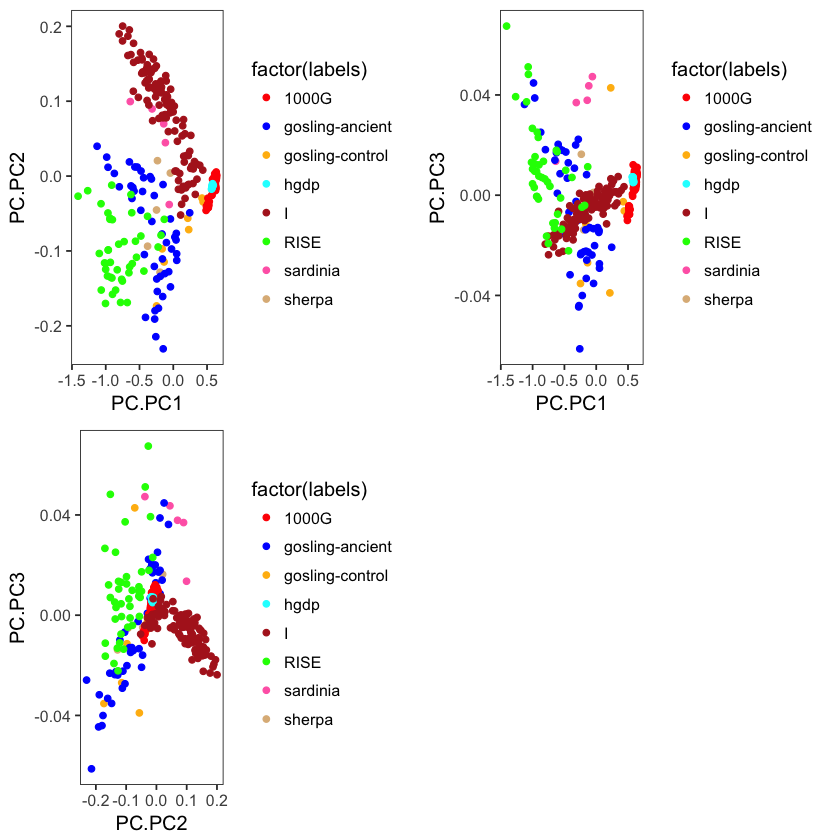

In [38]:
tmp <- gridPCA_signatures(mat, factor(labs), normalize = TRUE, cols=c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
                                                               "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
                                                               "brown4","darkorchid","magenta","yellow", "azure1","azure4"))


In [39]:
ll <- list()
#ll[["lindo-moderns"]] <- lindo_moderns_counts_CtoT
#ll[["lindo-old"]] <- lindo_ancients_counts_CtoT
ll[["sardinia"]] <- sardinia_counts_CtoT
ll[["sherpa"]] <- sherpa_counts_CtoT
ll[["gosling-control"]] <- gosling_controls_counts_CtoT
ll[["gosling-ancient"]] <- gosling_ancient_counts_CtoT
ll[["1000G"]] <- thousandg_counts_CtoT[1:100,]
ll[["hgdp"]] <- hgdp_counts_CtoT
#ll[["I"]] <- I_counts_CtoT
#ll[["RISE"]] <- RISE_counts_CtoT

mat <- do.call(rbind, ll);
labs <- unlist(lapply(1:length(ll), function(x) return (rep(names(ll)[x], dim(ll[[x]])[1]))))

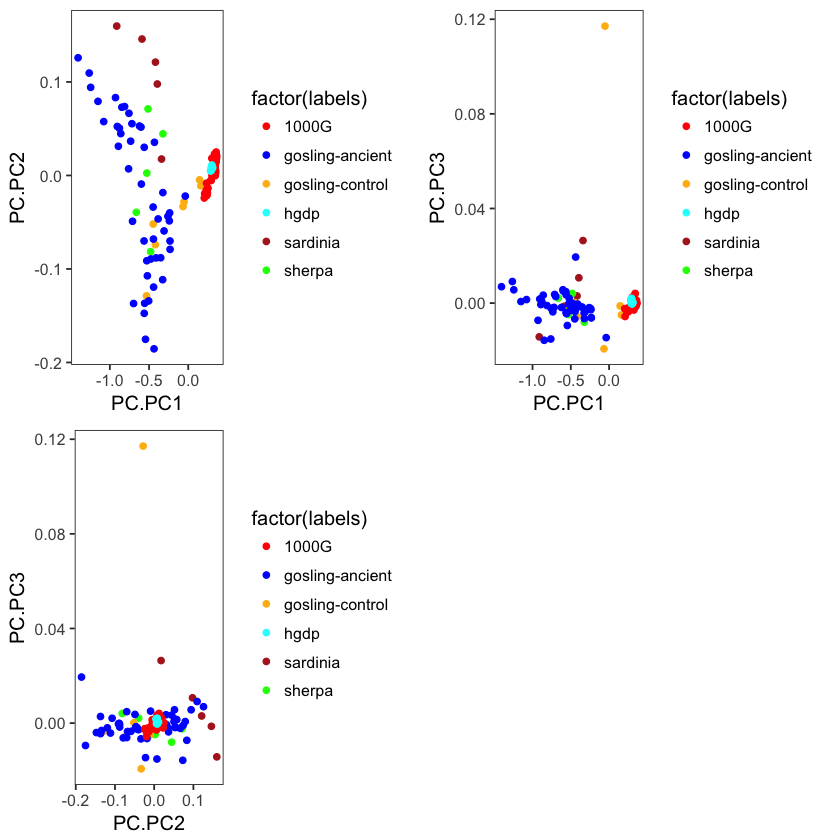

In [44]:
tmp <- gridPCA_signatures(mat, factor(labs), normalize = TRUE, cols=c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
                                                               "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
                                                               "brown4","darkorchid","magenta","yellow", "azure1","azure4"))


In [45]:
#################  Apply SVM classifier to get contamination rate  #####################################

####  Train: Moderns (1000G + HGDP)

####  Train: Ancients (Gossling Ancients + Sherpa)

####  Test:  Sardinia + Gossling controls

thousandg_names <- colnames(ll[["1000G"]])
hgdp_names <- colnames(ll[["hgdp"]])
gosling_ancient_names <-  colnames(ll[["gosling-ancient"]])
gosling_control_names <- colnames(ll[["gosling-control"]])
sherpa_names <- colnames(ll[["sherpa"]])
sardinia_names <- colnames(ll[["sardinia"]])
#lindo_moderns_names <- colnames(ll[["lindo-moderns"]])
#lindo_ancient_names <- colnames(ll[["lindo-old"]])

matched_names <- Reduce(intersect, list(thousandg_names, hgdp_names, gosling_ancient_names,
                                        gosling_control_names, sherpa_names, sardinia_names))
                                        #lindo_moderns_names, lindo_ancient_names))

trainX1 <- rbind(ll[["1000G"]][, match(matched_names, thousandg_names)],
                ll[["hgdp"]][, match(matched_names, hgdp_names)])

trainX2 <- rbind(ll[["sherpa"]][, match(matched_names, sherpa_names)],
                 ll[["gosling-ancient"]][, match(matched_names, gosling_ancient_names)])



trainX <- rbind(trainX1, trainX2)

testX <- rbind(ll[["sardinia"]][, match(matched_names, sardinia_names)],
               ll[["gosling-control"]][, match(matched_names, gosling_control_names)])

y <- c(rep("modern", dim(trainX1)[1]), rep("ancient", dim(trainX2)[1]))
y <- factor(y)

data <- cbind.data.frame(y, trainX);
out <- svm(y ~ ., data=data, probability=TRUE)

In [46]:
out


Call:
svm(formula = y ~ ., data = data, probability = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.1 

Number of Support Vectors:  13


In [47]:
temp = predict(out, testX, probability=TRUE)
temp

1       2       3       4       5       6       7       8       9      10 
ancient ancient ancient ancient ancient  modern  modern ancient ancient ancient 
     11      12 
ancient ancient 
attr(,"probabilities")
        modern    ancient
1  0.216663628 0.78333637
2  0.098673444 0.90132656
3  0.033128213 0.96687179
4  0.154086777 0.84591322
5  0.012345194 0.98765481
6  0.964009796 0.03599020
7  0.968399756 0.03160024
8  0.008099588 0.99190041
9  0.085075738 0.91492426
10 0.070892282 0.92910772
11 0.005075758 0.99492424
12 0.012912581 0.98708742
Levels: ancient modern

In [48]:
## Pool data from different sources

sardinia_counts <- get(load("../processed_data/sardinia2017.rda"))
temp <- club_signature_counts(sardinia_counts)
sardinia_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
sardinia_counts_CtoT <- filter_signatures_only_location(sardinia_counts_CtoT, max_pos = 10)



lindo_ancients_counts <- get(load("../processed_data/lindo2016ancients-counts-table.rda"))
temp <- club_signature_counts(lindo_ancients_counts)
lindo_ancients_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop=FALSE)
lindo_ancients_counts_CtoT <- filter_signatures_only_location(lindo_ancients_counts_CtoT, max_pos = 10)


lindo_moderns_counts <- get(load("../processed_data/lindo2016moderns-counts-table.rda"))
temp <- club_signature_counts(lindo_moderns_counts)
lindo_moderns_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
lindo_moderns_counts_CtoT <- filter_signatures_only_location(lindo_moderns_counts_CtoT, max_pos = 10)

gosling_counts <- get(load("../processed_data/annagosling2016-counts-table.rda"))
temp <- club_signature_counts(gosling_counts)
temp <- temp[-28,];
gosling_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
gosling_counts_CtoT <- filter_signatures_only_location(gosling_counts_CtoT, max_pos = 10)

sherpa_counts <- get(load("../processed_data/sherpa2017.rda"))
temp <- club_signature_counts(sherpa_counts)
sherpa_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
sherpa_counts_CtoT <- filter_signatures_only_location(sherpa_counts_CtoT, max_pos = 10)

thousandg_counts_clubbed <- get(load("../processed_data/1000Gmoderns-clubbed_counts-table.rda"))
temp <- thousandg_counts_clubbed
thousandg_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
thousandg_counts_CtoT <- filter_signatures_only_location(thousandg_counts_CtoT, max_pos = 10)

hgdp_counts <- get(load("../processed_data/HGDPmoderns-counts-table.rda"))
temp <- club_signature_counts(hgdp_counts)
hgdp_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
hgdp_counts_CtoT <- filter_signatures_only_location(hgdp_counts_CtoT, max_pos = 10)

names <- rownames(gosling_counts);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

gosling_controls_counts_CtoT <- gosling_counts_CtoT[control_indices,]
gosling_ancient_counts_CtoT <- gosling_counts_CtoT[-control_indices,]

I_counts <- get(load("../processed_data/Idata-counts-table.rda"))
temp <- club_signature_counts(I_counts)
I_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
I_counts_CtoT <- filter_signatures_only_location(I_counts_CtoT, max_pos = 10)

RISE_counts <- get(load("../processed_data/RISE-counts-table.rda"))
temp <- club_signature_counts(RISE_counts)
RISE_counts_CtoT <- filter_signatures_per_substitution(temp, pattern="C->T", use_prop = FALSE)
RISE_counts_CtoT <- filter_signatures_only_location(RISE_counts_CtoT, max_pos = 10)

In [52]:
ll <- list()
#ll[["lindo-moderns"]] <- lindo_moderns_counts_CtoT
#ll[["lindo-old"]] <- lindo_ancients_counts_CtoT
ll[["sardinia"]] <- sardinia_counts_CtoT
ll[["sherpa"]] <- sherpa_counts_CtoT
ll[["gosling-control"]] <- gosling_controls_counts_CtoT
ll[["gosling-ancient"]] <- gosling_ancient_counts_CtoT
ll[["1000G"]] <- thousandg_counts_CtoT[1:100,]
ll[["hgdp"]] <- hgdp_counts_CtoT
#ll[["I"]] <- I_counts_CtoT
#ll[["RISE"]] <- RISE_counts_CtoT

mat <- do.call(rbind, ll);
labs <- unlist(lapply(1:length(ll), function(x) return (rep(names(ll)[x], dim(ll[[x]])[1]))))


Estimating on a 174 document collection.
Fitting the 4 topic model.
log posterior increase: 3179556.03, 314344.3, 5129.24, 789.59, 527.32, 379.75, 284.98, 221.19, 174.07, 140.9, 115.84, 95.31, 808.54, 26.92, 7.72, 233.25, 4.12, 4.4, 4.12, 3.7, 3.33, 3.04, 2.82, 2.63, 2.47, 2.34, 2.22, 2.14, 2.17, 3.2, 0.95, 0.95, 1.03, 1.13, 1.36, 1.47, 1.5, 1.53, 1.6, 1.56, 1.51, 1.49, 1.53, 1.73, 3.64, 1.48, 3.01, 0.48, 0.73, 0.62, 0.43, 6.31, 3.7, 2.6, 1.98, 1.54, 1.23, 1.01, 0.85, 0.73, 0.64, 0.56, 0.51, 0.47, 0.43, 0.4, 0.38, 0.36, 0.35, 0.33, 0.32, 0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.21, 0.2, 0.19, 0.18, 0.18, 0.17, 0.16, 0.16, 0.15, 0.15, 0.14, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12, p 10 iter 1000 diff 0
0.12, 0.12, 0.13, 0.16, 0.38, 0.1, 0.11, 0.15, 0.07, 0.08, 0.1, 0.24, 0.03, 0.02, 1.85, 0.02, 0.02, 2.35, 0.26, 0.01, 0.01, 0.08, 0.01, done.


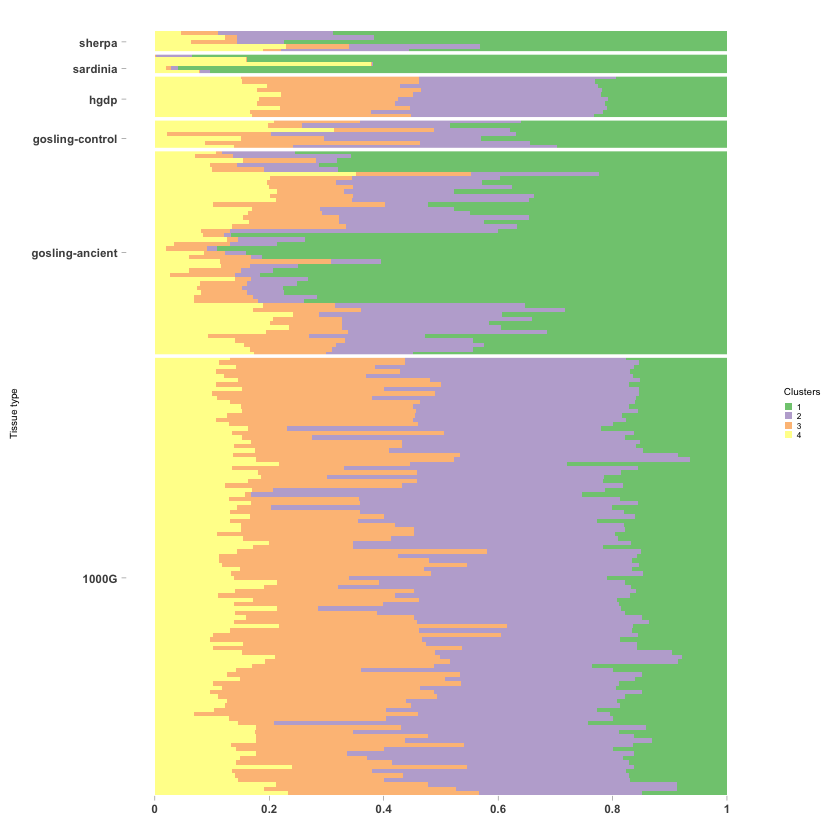

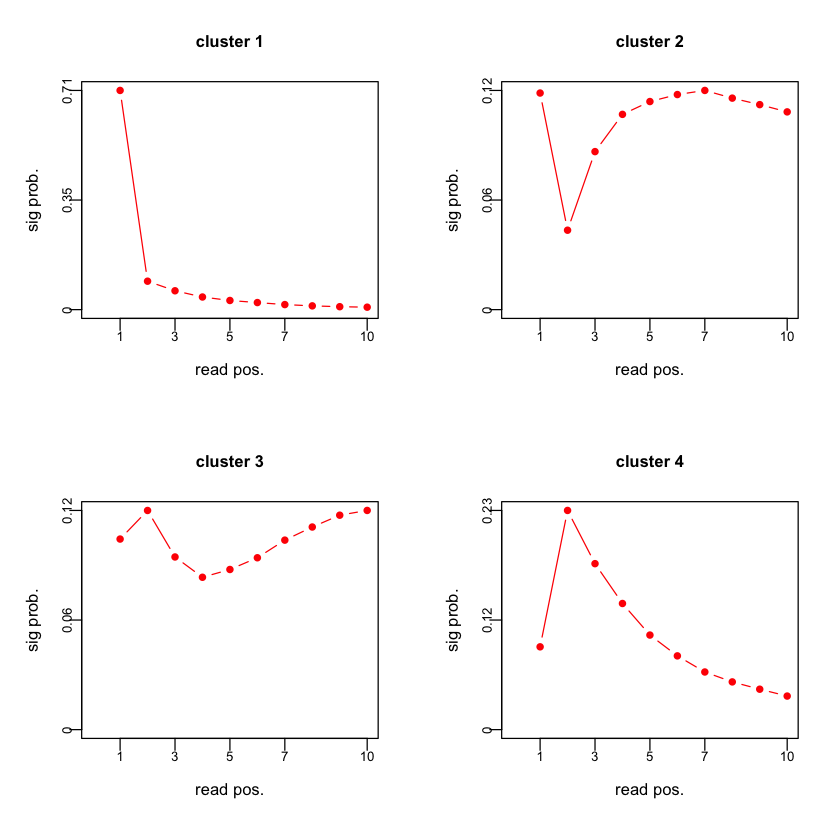

In [53]:
topic_clus <- maptpx::topics(mat, K=4, tol=0.01)
omega <- topic_clus$omega;
annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs))


CountClust::StructureGGplot(omega = as.matrix(omega),
                            annotation = annotation,
                            palette = RColorBrewer::brewer.pal(8, "Accent"),
                            yaxis_label = "Tissue type",
                            order_sample = FALSE,
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))

plot_graph <- function(probs, max_pos, max_prob, col="red",
                       cex=unit(1, "npc"), pch=unit(16,"npc"),
                       xlab="read pos.", ylab="sig prob.",
                       main="",
                       cex.axis=unit(0.8, "npc"),
                       cex.main=unit(1, "npc")){
  # if (length(probs) != max_pos){
  #   stop(cat('probability vector must be of length ', max_pos))
  # }
  plot(as.numeric(names(probs)), probs/max_prob, xlim = c(0, max_pos), ylim=c(0,1),
       type = "b", xaxt = "n", yaxt = "n", cex = cex, pch=pch, col=col, main=main,
       cex.main=cex.main, ylab="", xlab="")
  axis(side = 1, at = floor(seq(1, max_pos, length.out=5)), cex.axis = cex.axis, lwd.ticks = 1, tck=-0.05,
       cex.lab=0.5, mgp=c(1, 0.3, 0))
  title(xlab = xlab, mgp=c(2,1,0))
  ylimit <- c(0.0, 0.5, 1.0)*max_prob
  axis(side = 2, at = c(0.0, 0.5, 1.0), labels = round(ylimit,2), cex.axis = cex.axis, lwd.ticks=1, tck=-0.05,
       cex.lab=0.5, mgp=c(1, 0.3, 0))
  title(ylab = ylab, mgp=c(2,1,0))
}


par(mfrow=c(2,2))
plot_graph(topic_clus$theta[,1], max_pos=10, max_prob=max(topic_clus$theta[,1]), main="cluster 1")
plot_graph(topic_clus$theta[,2], max_pos=10, max_prob=max(topic_clus$theta[,2]), main="cluster 2")
plot_graph(topic_clus$theta[,3], max_pos=10, max_prob=max(topic_clus$theta[,3]), main="cluster 3")
plot_graph(topic_clus$theta[,4], max_pos=10, max_prob=max(topic_clus$theta[,4]), main="cluster 4")


Estimating on a 174 document collection.
log posterior increase: 1.7005, done.


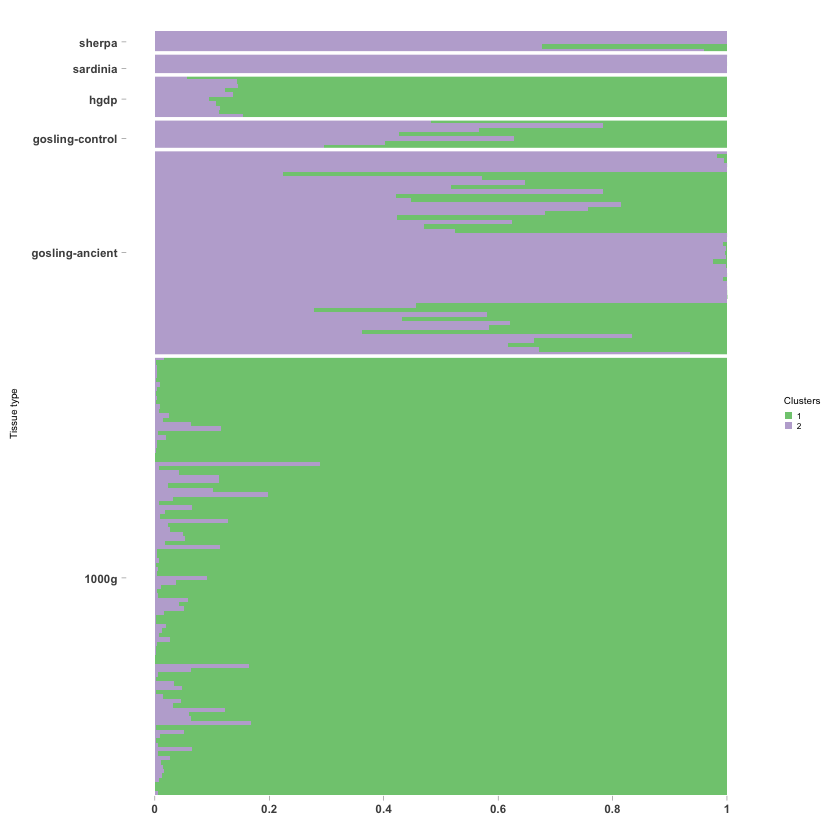

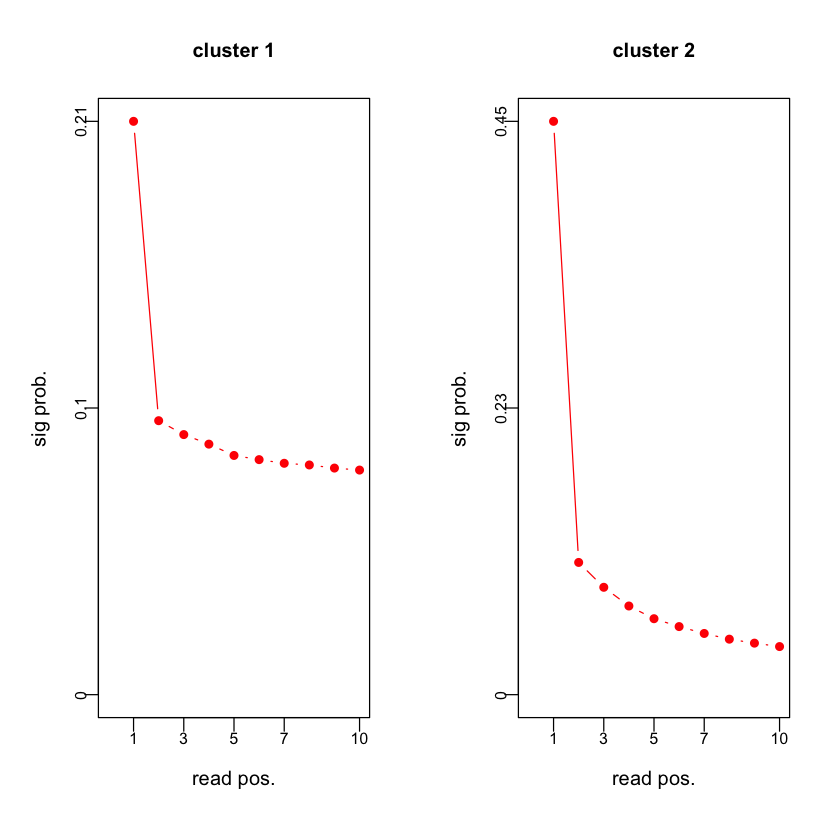

In [55]:
library(classtpx)

thousandg_names <- colnames(ll[["1000G"]])
hgdp_names <- colnames(ll[["hgdp"]])
gosling_ancient_names <-  colnames(ll[["gosling-ancient"]])
gosling_control_names <- colnames(ll[["gosling-control"]])
sherpa_names <- colnames(ll[["sherpa"]])
sardinia_names <- colnames(ll[["sardinia"]])
#lindo_moderns_names <- colnames(ll[["lindo-moderns"]])
#lindo_ancient_names <- colnames(ll[["lindo-old"]])

matched_names <- Reduce(intersect, list(thousandg_names, hgdp_names, gosling_ancient_names,
                                        gosling_control_names, sherpa_names, sardinia_names))
                                        #lindo_moderns_names, lindo_ancient_names))

trainX1 <- rbind(ll[["1000G"]][, match(matched_names, thousandg_names)],
                ll[["hgdp"]][, match(matched_names, hgdp_names)])

trainX2 <- rbind(ll[["sherpa"]][, match(matched_names, sherpa_names)],
                 ll[["gosling-ancient"]][, match(matched_names, gosling_ancient_names)])



trainX <- rbind(trainX1, trainX2)

testX <- rbind(ll[["sardinia"]][, match(matched_names, sardinia_names)],
               ll[["gosling-control"]][, match(matched_names, gosling_control_names)])


pooled_data <- rbind(trainX, testX);
class_labs <- c(rep(1, dim(trainX1)[1]), rep(2, dim(trainX2)[1]))
known_samples <- 1:(dim(trainX1)[1] + dim(trainX2)[1])

#pooled_data <- floor(10^20*pooled_data);
Topic_clus <- class_topics(
  as.matrix(pooled_data),
  K=2,
  known_samples = known_samples,
  class_labs = class_labs,
  method="theta.fix",
  shrink=FALSE,
  shrink.method = 1,
  tol=0.0001,
  ord=FALSE)

labs <- c(rep("1000g", dim(ll[["1000G"]])[1]), rep("hgdp", dim(ll[["hgdp"]])[1]),
          rep("sherpa", dim(ll[["sherpa"]])[1]), rep("gosling-ancient", dim(ll[["gosling-ancient"]])[1]),
          rep("sardinia", dim(ll[["sardinia"]])[1]), rep("gosling-control", dim(ll[["gosling-control"]])[1]))

omega <- Topic_clus$omega;
annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs))


CountClust::StructureGGplot(omega = as.matrix(omega),
                            annotation = annotation,
                            palette = RColorBrewer::brewer.pal(8, "Accent"),
                            yaxis_label = "Tissue type",
                            order_sample = FALSE,
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))

par(mfrow=c(1,2))
plot_graph(Topic_clus$theta[,1], max_pos=10, max_prob=max(Topic_clus$theta[,1]), main="cluster 1")
plot_graph(Topic_clus$theta[,2], max_pos=10, max_prob=max(Topic_clus$theta[,2]), main="cluster 2")

## Summary

In this script, we made a first pass at classifying ancient and modern samples. We found that after training that the 
ancient samples have a steeper C to T fall pattern, whereas the pattern is much flatter for the modern samples. We also found in PCA analysis that the moderns and the ancients sort of separate out and the control samples form a bridge between them. This is very encouraging.

In [35]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.12 (Sierra)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] classtpx_0.99.0  slam_0.1-40      e1071_1.6-7      limma_3.30.7    
 [5] dplyr_0.5-1      plyr_1.8.4       gridBase_0.4-7   maptpx_1.9-3    
 [9] CountClust_0.1.2 ggplot2_2.2.1    aRchaic_0.99.0  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8         RColorBrewer_1.1-2  class_7.3-14       
 [4] tools_3.3.1         boot_1.3-18         digest_0.6.11      
 [7] uuid_0.1-2          nlme_3.1-128        jsonlite_1.2       
[10] evaluate_0.10       tibble_1.2          gtable_0.2.0       
[13] lattice_0.20-34     mgcv_1.8-16         Matrix_1.2-7.1     
[16] DBI_0.5-1           IRdisplay_0.4.4     parallel_3.3.1     
[19] IRkernel_0.7.1      gridExtra_2.2.1 